In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit import rdBase
from rdkit import DataStructs


from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import tensorflow as tf

In [31]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [ ]:
#export DGLBACKEND=[tensorflow]

In [ ]:
#import dgllife

In [ ]:
#from dgllife.utils import mol_to_complete_graph
#from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer

## preprocess(select subset)

In [26]:
ihbt = pd.read_csv('AID1706_binarized_sars.csv')
ihbt = ihbt[['smiles','activity'] ]

In [48]:
ihbt

,smiles,activity
0,CC1=CC=C(O1)C(C(=O)NCC2=CC=CO2)N(C3=CC=C(C=C3)...,1
1,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)S(=O)(=O)C3=C...,1
2,CC1=CC2=C(C=C1)NC(=O)C(=C2)CN(CCC3=CC=CC=C3)CC...,1
3,CC1=CC=C(C=C1)CN(C(C2=CC=CS2)C(=O)NCC3=CC=CO3)...,1
4,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,1
...,...,...
290721,COCCN1C2=C(C=C(C=C2)C(=O)OC)SC1=NC(=O)CCS(=O)(...,0
290722,COC1=CC=C(C=C1)C2CC(=NN2C(=O)CSC3=NCCS3)C4=CC=CS4,0
290723,CC1CC(=O)N(C2=CC=CC=C2S1(=O)=O)CC(=O)NC3=CC=CC...,0
290724,COC1=C2C(=C(C=C1)OC)SC(=N2)NC(=O)C3=CC(=CC=C3)...,0


In [49]:
ihbt.groupby('activity').count()

,smiles
activity,
0,290321
1,405


In [51]:
ihbt_true = ihbt[ihbt['activity']==1]
ihbt_false = ihbt[ihbt['activity']==0]

In [52]:
ihbt_false

,smiles,activity
405,CCOCCCNCC(=O)NC1=CC=C(C=C1)OC(F)(F)F.Cl,0
406,COCCN1C(=NN=N1)CN2CCC(CC2)CC3=CC=CC=C3.Cl,0
407,COCCN1C(=NN=N1)CN2CCC(CC2)(C3=CC(=CC=C3)C(F)(F...,0
408,C1CCCN(CC1)CC(=O)NCCC2=CC=C(C=C2)F.C(=O)(C(=O)O)O,0
409,COC1=CC=C(C=C1)C(=O)C(C2=CC=CC=C2)N3CCOCC3.Cl,0
...,...,...
290721,COCCN1C2=C(C=C(C=C2)C(=O)OC)SC1=NC(=O)CCS(=O)(...,0
290722,COC1=CC=C(C=C1)C2CC(=NN2C(=O)CSC3=NCCS3)C4=CC=CS4,0
290723,CC1CC(=O)N(C2=CC=CC=C2S1(=O)=O)CC(=O)NC3=CC=CC...,0
290724,COC1=C2C(=C(C=C1)OC)SC(=N2)NC(=O)C3=CC(=CC=C3)...,0


In [56]:
ihbt_false_short = resample(ihbt_false, n_samples=800, replace = False)
#ihbt_ = ihbt_false_short + ihbt_true

In [64]:
ihbt_ = pd.concat([ihbt_false_short , ihbt_true], ignore_index =  True)#.reset_index()

In [66]:
ihbt_#.groupby('ac').count()

,smiles,activity
0,C1COCCN1C(=O)CSC2=NNC(=N2)C3=CC=CC=C3,0
1,C1=CC=C(C=C1)C2=CSC(=N2)SCC(=O)NC3=CC=CC=C3[N+...,0
2,CC1=CC2=C(C=C1)OC(=O)N2CC(=O)OC,0
3,C1CCN2C(C1)C(=O)N(C3=CC=CC=C3C2=O)CC(=O)N.C(=O...,0
4,C1CCN(CC1)CCN2C3=CC=CC=C3N4C2=NC(=O)C(=N4)CCC(...,0
...,...,...
1200,C1COC2=C(O1)C=CC(=C2)NC(=O)C3=C(OC=N3)C4=CC=CC=C4,1
1201,COC(=O)C1=CC=CC=C1NC(=O)C2=CC3=C(C=C2)OCCCO3,1
1202,COC1=CC=CC=C1CCNC(=O)C(=O)NCC2N(CCO2)S(=O)(=O)...,1
1203,CN(C)CCNC(=O)C(=O)NCC1N(CCO1)S(=O)(=O)C2=CC=C(...,1


# Model building(dense layer model)

## Train Test Split

In [68]:
def mol2arr(mol):
    '''
    get the morgan finger print as an array for a rdkit molecule
    parameter mol: rdkit molecule format
    return arr: array for that molecule, containing its finger print
    '''
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [76]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]
X = np.array([mol2arr(mol) for mol in mols])
y = ihbt_['activity']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [85]:
X.shape

(1205, 2048)

## Dense layer Model

In [87]:
from tensorflow.keras import layers

In [183]:
model = tf.keras.models.Sequential([
    layers.Dense(500, input_shape = (2048,)),
    layers.Dense(500),
    layers.Dense(500),
    layers.Dense(2)
])

In [184]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1002      
Total params: 1,526,502
Trainable params: 1,526,502
Non-trainable params: 0
_________________________________________________________________


In [185]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ["accuracy"])

In [186]:
history = model.fit(X_train, y_train, epochs = 100, verbose=1)

Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 0.7082 - accuracy: 0.6326
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3627 - accuracy: 0.8571
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1827 - accuracy: 0.9239
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0780 - accuracy: 0.9699
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0938 - accuracy: 0.9675
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0566 - accuracy: 0.9754
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0342 - accuracy: 0.9893
Epoch 8/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0445 - accuracy: 0.9846
Epoch 9/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 0.9954
Epoch 10/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0084 - accuracy: 0.9973
Epoch 11/

27/27 [==============================] - 0s 5ms/step - loss: 3.1869e-06 - accuracy: 1.0000
Epoch 81/100
27/27 [==============================] - 0s 5ms/step - loss: 3.7902e-06 - accuracy: 1.0000
Epoch 82/100
27/27 [==============================] - 0s 5ms/step - loss: 2.5693e-06 - accuracy: 1.0000
Epoch 83/100
27/27 [==============================] - 0s 4ms/step - loss: 3.5320e-06 - accuracy: 1.0000
Epoch 84/100
27/27 [==============================] - 0s 5ms/step - loss: 3.3260e-06 - accuracy: 1.0000
Epoch 85/100
27/27 [==============================] - 0s 5ms/step - loss: 2.4038e-06 - accuracy: 1.0000
Epoch 86/100
27/27 [==============================] - 0s 5ms/step - loss: 2.2438e-06 - accuracy: 1.0000
Epoch 87/100
27/27 [==============================] - 0s 5ms/step - loss: 2.6068e-06 - accuracy: 1.0000
Epoch 88/100
27/27 [==============================] - 0s 5ms/step - loss: 2.2495e-06 - accuracy: 1.0000
Epoch 89/100
27/27 [==============================] - 0s 5ms/step - loss: 2.7

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

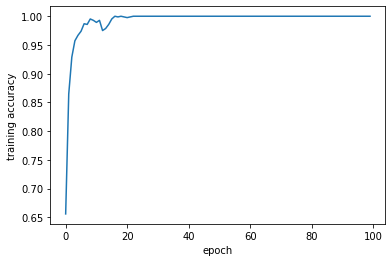

In [187]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [188]:
model.evaluate(X_test, y_test, verbose = 2)

12/12 - 0s - loss: 5.4237 - accuracy: 0.7099


[5.4236907958984375, 0.7099447250366211]

### GAN

In [79]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (2048,) , strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    #model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

## Graph CNN

In [128]:
import torch

In [111]:
import dgllife

In [113]:
from dgllife.utils import mol_to_complete_graph,smiles_to_complete_graph
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import *

In [112]:
g = dgllife.utils.smiles_to_bigraph('CCO')
print(g)

Graph(num_nodes=3, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


In [140]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]

In [149]:
from functools import partial

In [145]:
def featurize_atoms(mol):
    feats = []
    for atom in mol.GetAtoms():
        feats.append(atom.GetAtomicNum())
    return {'atomic': torch.tensor(feats).reshape(-1, 1).float()}

In [159]:
def featurize_edges(mol, add_self_loop=False):
    feats = []
    num_atoms = mol.GetNumAtoms()
    atoms = list(mol.GetAtoms())
    CanonicalBondFeaturizer(bond_data_field='feat')
    #distance_matrix = Chem.GetDistanceMatrix(mol)
    #for i in range(num_atoms):
        #for j in range(num_atoms):
            #if i != j or add_self_loop:
                feats.append(float(distance_matrix[i, j]))
    return {'dist': torch.tensor(feats).reshape(-1, 1).float()}

In [160]:
mol = Chem.MolFromSmiles('C1COCCN1C(=O)CSC2=NNC(=N2)C3=CC=CC=C3')
#add_self_loop = True 
g = mol_to_complete_graph(
         mol, add_self_loop=True, node_featurizer=featurize_atoms,
         edge_featurizer=partial(featurize_edges, add_self_loop=True))

In [168]:
g

Graph(num_nodes=21, num_edges=441,
      ndata_schemes={'atomic': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'dist': Scheme(shape=(1,), dtype=torch.float32)})

### Future steps

- improve the performance of the dense layer model(train it with a complete dataset)
- find a way to input the dgl graph object into GCN
- create the generator of the generative adversial network

In [109]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
_feats = atom_featurizer.feat_size('h')
#train_x= [mol_to_complete_graph(m, node_featurizer=node_featurizer) for m in mols]
#train_y = np.array(df['activity'])
#train_y = np.array(train_y, dtype=np.int64)



NameError: name 'atom_featurizer' is not defined

In [175]:
import deepchem as dc

In [176]:
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
out = featurizer.featurize(smiles)

In [182]:
out

array([<deepchem.feat.graph_data.GraphData object at 0x7fee70856850>,
      dtype=object)

In [172]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='feat')
#edge_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
#n_feats = atom_featurizer.feat_size('h')
train_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer) for m in mols]



DGLError: Expect number of features to match number of edges. Got 46 and 420 instead.

In [171]:
train_g[0]

Graph(num_nodes=21, num_edges=420,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={})

In [135]:
#cat = tf.train_g[0].ndata
#pytorch_tensor = train_g[0].ndata
#np_tensor = pytorch_tensor.numpy()
#tf_tensor = tf.convert_to_tensor(np_tensor)

In [115]:
smiles_to_complete_graph('C1COCCN1C(=O)CSC2=NNC(=N2)C3=CC=CC=C3')

Graph(num_nodes=21, num_edges=420,
      ndata_schemes={}
      edata_schemes={})

In [116]:
smiles_to_complete_graph('CC1=CC2=C(C=C1)OC(=O)N2CC(=O)OC')

Graph(num_nodes=16, num_edges=240,
      ndata_schemes={}
      edata_schemes={})

In [15]:
trainX = np.array([mol2arr(mol) for mol in mols])
#trainY = [sol_class[mol.GetProp("SOL_classification")] for mol in train_mols]
#trainY = np_utils.to_categorical(trainY)
 
#testX = np.array([mol2arr(mol) for mol in test_mols])
#testY = [sol_class[mol.GetProp("SOL_classification")] for mol in test_mols]
#testY = np_utils.to_categorical(testY)


In [ ]:
pip uninstall dgl -y